# Imports and Defaults

In [99]:
import json
import os
from collections import namedtuple
from functools import lru_cache
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
sns.set_theme(font_scale=16, style="whitegrid")
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
})

seed = 1234
rng = np.random.default_rng(seed)

In [101]:
posterior = "rosenbrock2"

# Load Data

In [160]:
fname = f"../../data/{posterior}/baseline"

drghmc_sampler = "adapt_metric=False__damping=0.08__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size_factor=1"
drhmc_sampler = "adapt_metric=False__damping=1.0__max_proposals=3__metric=1__probabilistic=False__reduction_factor=3__sampler_type=drhmc__step_count_factor=0.9__step_size_factor=1"
nuts_sampler = "adapt_metric=False__metric=identity__sampler_type=nuts"
ghmc_sampler = "adapt_metric=False__damping=0.08__max_proposals=1__metric=1__probabilistic=False__reduction_factor=4__sampler_type=ghmc__step_count_method=const_step_count__step_size_factor=1"
hmc_sampler = "adapt_metric=False__damping=1.0__metric=1__probabilistic=False__sampler_type=hmc__step_count_factor=0.9__step_size_factor=1"

In [161]:
def get_fname(sampler, chain):
    return os.path.join(fname, sampler, f"history__chain={chain}.npz")

def get_chain_data(sampler, chain, downsample=1):
    data = np.load(get_fname(sampler, chain))
    return data["draws"][::downsample], data["grad_evals"][::downsample]

In [162]:
def get_data(sampler):
    data_list, grad_list = [], []
    for chain in range(100):
        try:
            draws, grad_evals = get_chain_data(sampler, chain) # draws = (n_samples, n_params)
            data_list.append(draws)
            grad_list.append(np.array(grad_evals))
            del draws, grad_evals
        except Exception as e:
            print(e)
            
    
    # do not stack b/c variable len chains
    return data_list, grad_list

In [163]:
drhmc_data, drhmc_grads = get_data(drhmc_sampler)
drghmc_data, drghmc_grads = get_data(drghmc_sampler)
nuts_data, nuts_grads = get_data(nuts_sampler)
ghmc_data, ghmc_grads = get_data(ghmc_sampler)
hmc_data, hmc_grads = get_data(hmc_sampler)

here
2
3
4


In [164]:
TrueParams = namedtuple('TrueParams', ['p1_mean', 'p1_std', 'p2_mean', 'p2_std'])

def load_true_params(posterior):
    ref_draws_fname = os.path.join(f"../../posteriors/{posterior}/{posterior}.ref_draws.json.zip")
    with ZipFile(ref_draws_fname) as z:
        with z.open(f"{posterior}.ref_draws.json") as f:
            ref_draws = json.load(f)
    return ref_draws

def compute_true_params(posterior):
    ref_draws_raw = load_true_params(posterior) # list of dicts
    ref_draws = np.array([list(d.values()) for d in ref_draws_raw]) # [num_chains, num_params, num_samples]
    # ref_draws = np.array(list(ref_draws_chains[0].values()))
    tp = TrueParams(
        p1_mean=np.mean(ref_draws, axis=(0, 2)),
        p1_std=np.std(ref_draws, axis=(0, 2)),
        p2_mean=np.mean(ref_draws**2, axis=(0, 2)),
        p2_std=np.std(ref_draws**2, axis=(0, 2))
    )
    del ref_draws, ref_draws_raw
    return tp

In [165]:
tp = compute_true_params(posterior)

In [166]:
drghmc_avg = np.mean(np.concatenate(drghmc_data), axis=0)
drhmc_avg = np.mean(np.concatenate(drhmc_data), axis=0) 
nuts_avg = np.mean(np.concatenate(nuts_data), axis=0)
ghmc_avg = np.mean(np.concatenate(ghmc_data), axis=0)
hmc_avg = np.mean(np.concatenate(hmc_data), axis=0)

print(f"DRGHMC: {drghmc_avg}")
print(f"DRHMC: {drhmc_avg}")
print(f"NUTS: {nuts_avg}")
print(f"GHMC: {ghmc_avg}")
print(f"HMC: {hmc_avg}")

DRGHMC: [0.99896134 1.99691188]
DRHMC: [0.99803202 1.99318593]
NUTS: [0.94674911 1.83336815]
GHMC: [0.99526303 1.96874404]
HMC: [1.2873239  2.76375579]


In [167]:
drghmc_all_data = np.concatenate(drghmc_data)
drhmc_all_data = np.concatenate(drhmc_data)
nuts_all_data = np.concatenate(nuts_data)
ghmc_all_data = np.concatenate(ghmc_data)
hmc_all_data = np.concatenate(hmc_data)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


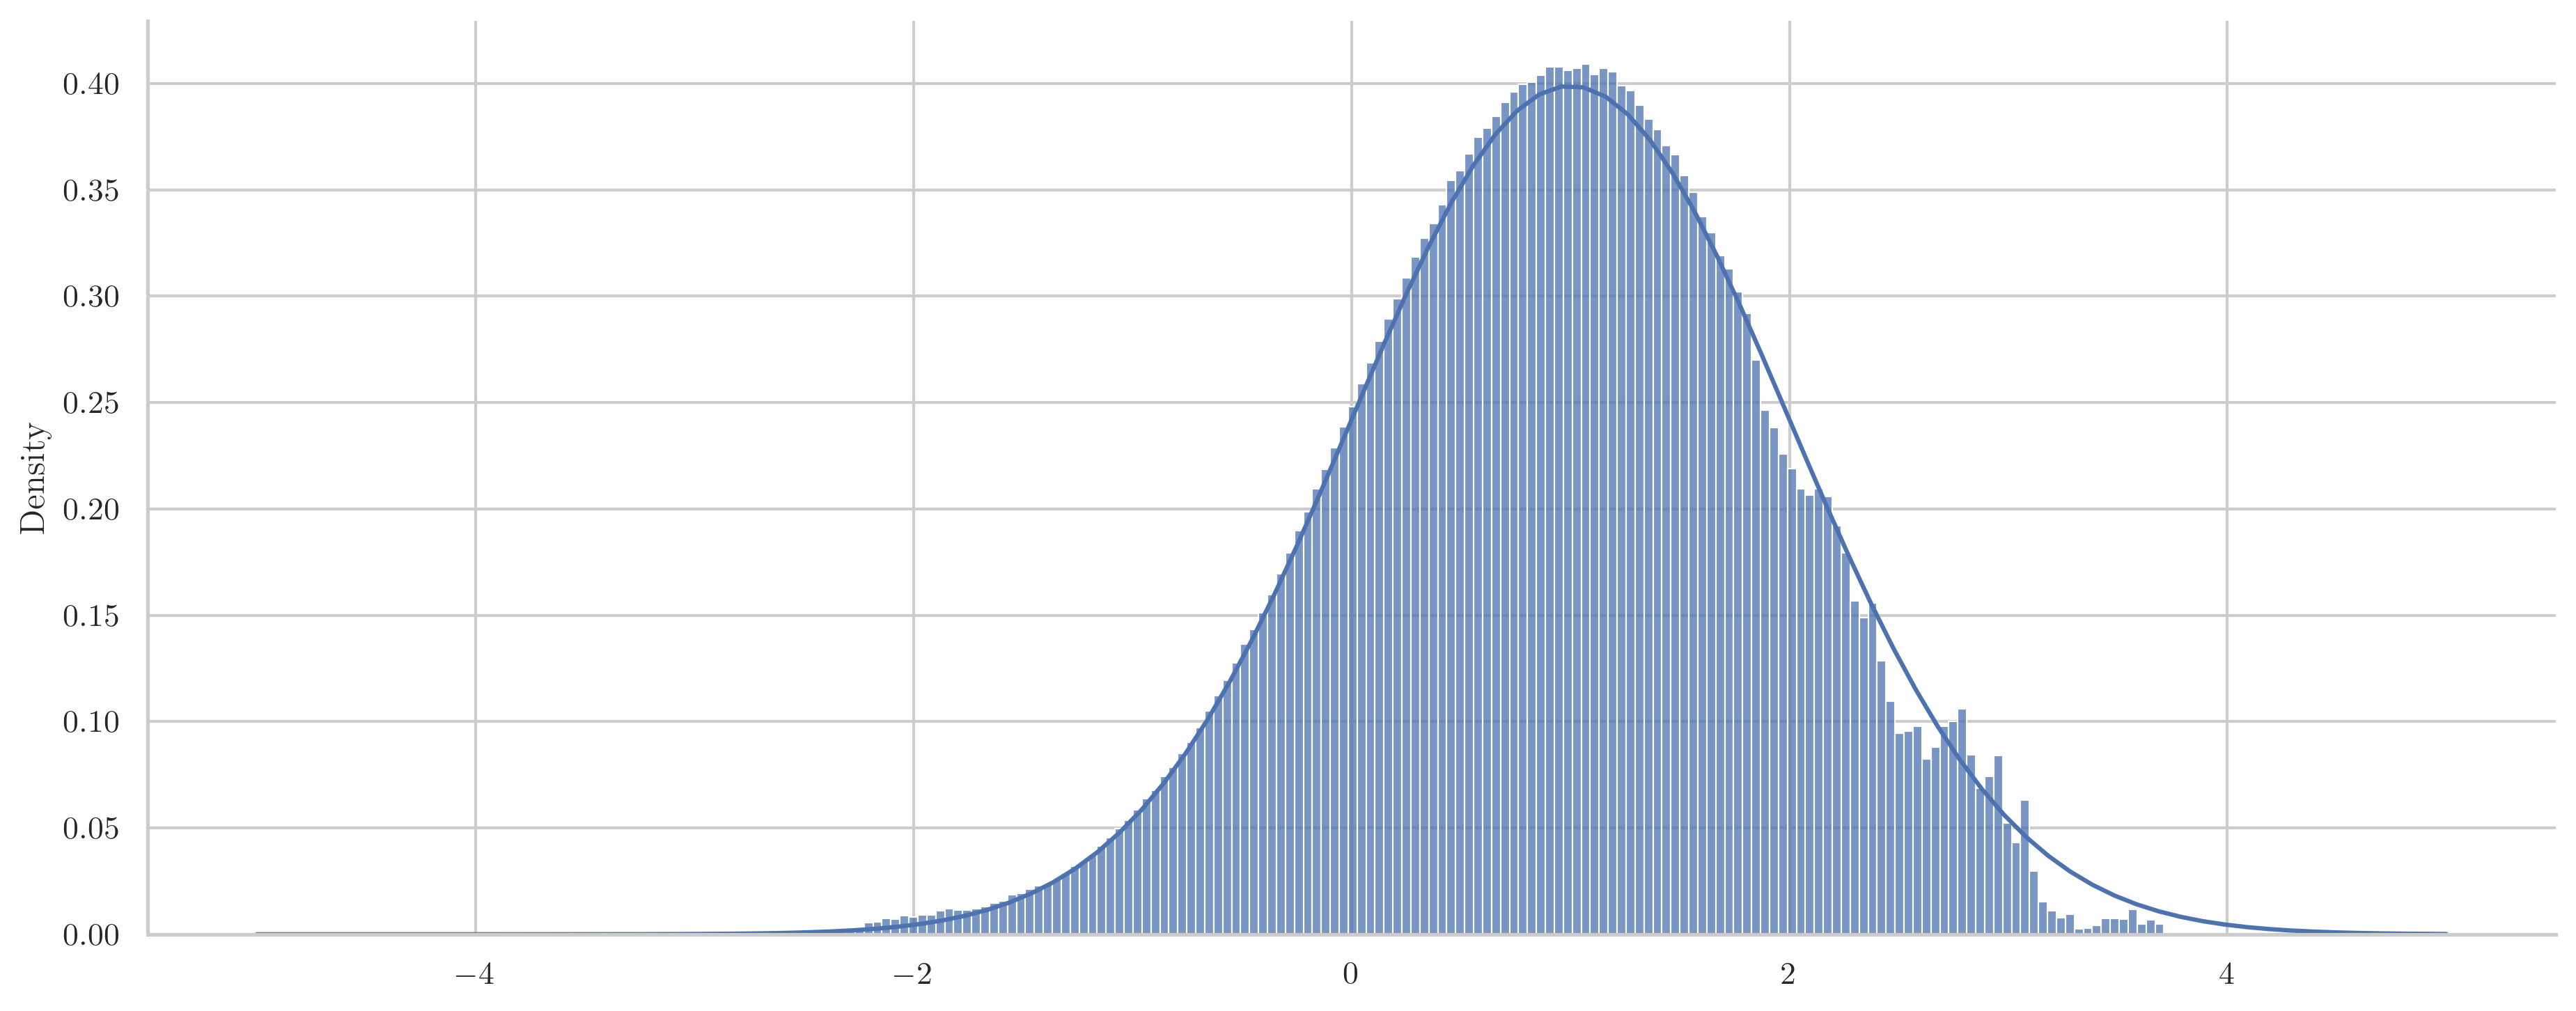

In [181]:
chain = 6

fig = sns.displot(
    kind="hist",
    x=nuts_all_data[:, 0],
    # y=nuts_all_data[:, 3],
    bins=150,
    stat="density",
    aspect=2.5,
)

# normal(1, 1)
x = np.linspace(-5, 5, 100)
y = 1/np.sqrt(2*np.pi) * np.exp(-0.5 * (x - 1)**2)
plt.plot(x, y, label="True")